In [34]:
import numpy as np
import pandas as pd

In [35]:
import os
import sys
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz, vstack, hstack, lil_matrix
#import implicit
import pickle
#from implicit.evaluation import train_test_split, precision_at_k, mean_average_precision_at_k

def load_data():
    '''load the MovieLens 1m dataset in a Pandas dataframe'''
    ratings = pd.read_csv('/content/ratings.dat', delimiter='::', header=None,
        names=['user_id', 'movie_id', 'rating', 'timestamp'],
        usecols=['user_id', 'movie_id', 'rating'], engine='python')

    return ratings


In [36]:
def load_movies_data():
    '''load the MovieLens 1m dataset in a Pandas dataframe'''
    movies = pd.read_csv('/content/movies.dat', delimiter='::', header=None,
        names=['movie_id','title','genres'],
        usecols=['movie_id','title','genres'], engine='python',encoding='latin-1')

    return movies

In [37]:
def load_users_data():
    '''load the MovieLens 1m dataset in a Pandas dataframe'''
    users = pd.read_csv('/content/users.dat', delimiter='::', header=None,
        names=['user_id','Gender','Age','Occupation','Zip-code'],
        usecols=['user_id','Age'], engine='python',encoding='latin-1')

    return users

In [38]:
users_s=load_users_data()
users_s
age=users_s.Age
age

0        1
1       56
2       25
3       45
4       25
        ..
6035    25
6036    45
6037    56
6038    45
6039    25
Name: Age, Length: 6040, dtype: int64

In [39]:
ratings = load_data()
ratings


,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [40]:
movies = load_movies_data()
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [41]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [42]:
ratings = pd.merge(ratings,movies,on='movie_id')
ratings.head()

,user_id,movie_id,rating,title,genres
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975),Drama


# EDA

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [44]:
ratings.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Ulysses (Ulisse) (1954)     5.0
Lured (1947)                5.0
Follow the Bitch (1998)     5.0
Bittersweet Motel (2000)    5.0
Song of Freedom (1936)      5.0
Name: rating, dtype: float64

In [45]:
ratings.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Name: rating, dtype: int64

In [46]:
rating = pd.DataFrame(ratings.groupby('title')['rating'].mean())
rating.head()

,rating
title,
"$1,000,000 Duck (1971)",3.027027
'Night Mother (1986),3.371429
'Til There Was You (1997),2.692308
"'burbs, The (1989)",2.910891
...And Justice for All (1979),3.713568


In [47]:
rating['num of ratings'] = pd.DataFrame(ratings.groupby('title')['rating'].count())
rating.head()

,rating,num of ratings
title,,
"$1,000,000 Duck (1971)",3.027027,37
'Night Mother (1986),3.371429,70
'Til There Was You (1997),2.692308,52
"'burbs, The (1989)",2.910891,303
...And Justice for All (1979),3.713568,199


<Axes: >

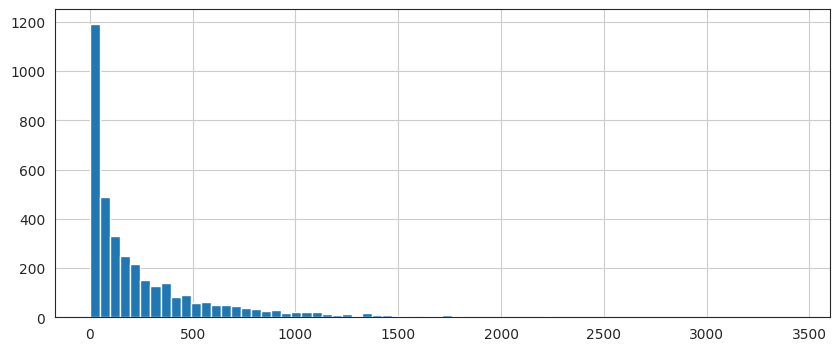

In [48]:
plt.figure(figsize=(10,4))
rating['num of ratings'].hist(bins=70)

<Axes: >

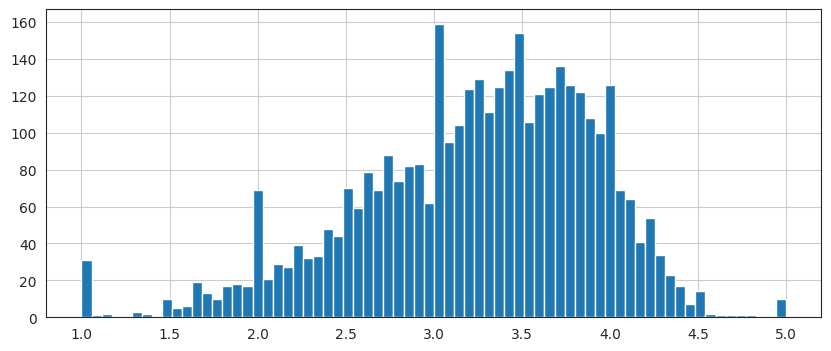

In [49]:
plt.figure(figsize=(10,4))
rating['rating'].hist(bins=70)

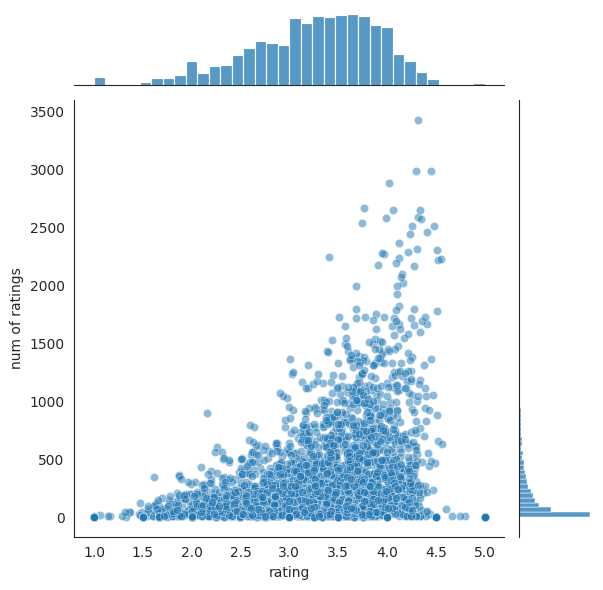

In [50]:
sns.jointplot(x='rating',y='num of ratings',data=rating,alpha=0.5)

Recommending Similar Movies

In [51]:
moviemat = ratings.pivot_table(index='user_id',columns='movie_id',values='rating')
moviemat.tail()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6040,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
rating.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
American Beauty (1999),4.317386,3428
Star Wars: Episode IV - A New Hope (1977),4.453694,2991
Star Wars: Episode V - The Empire Strikes Back (1980),4.292977,2990
Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
Jurassic Park (1993),3.763847,2672
Saving Private Ryan (1998),4.337354,2653
Terminator 2: Judgment Day (1991),4.058513,2649
"Matrix, The (1999)",4.315830,2590
Back to the Future (1985),3.990321,2583


In [53]:
rating.head()

,rating,num of ratings
title,,
"$1,000,000 Duck (1971)",3.027027,37
'Night Mother (1986),3.371429,70
'Til There Was You (1997),2.692308,52
"'burbs, The (1989)",2.910891,303
...And Justice for All (1979),3.713568,199


pearson corelation

In [54]:
import numpy as np

def custom_similarity_with_age_proximity(ratings1, ratings2, age1, age2):
    # Find the movies that both users have rated
    common_movies = np.logical_and(~np.isnan(ratings1), ~np.isnan(ratings2))

    # If no common movies, return NaN
    if not np.any(common_movies):
        return np.nan

    # Extract ratings for common movies
    ratings1_common = ratings1[common_movies]
    ratings2_common = ratings2[common_movies]

    # Calculate mean ratings for both users
    mean_ratings1 = np.nanmean(ratings1)
    mean_ratings2 = np.nanmean(ratings2)

    # Calculate the covariance and variances
    numerator = np.sum((ratings1_common - mean_ratings1) * (ratings2_common - mean_ratings2))
    denominator1 = np.sqrt(np.sum((ratings1_common - mean_ratings1) ** 2))
    denominator2 = np.sqrt(np.sum((ratings2_common - mean_ratings2) ** 2))

    # Handle division by zero
    if denominator1 == 0 or denominator2 == 0:
        return np.nan

    # Calculate Pearson correlation coefficient
    correlation = numerator / (denominator1 * denominator2)

    # Calculate age proximity similarity
    age_similarity = 1 / (1 + np.abs(age1 - age2))

    # Combine similarity and age proximity with weights
    similarity_with_age = 0.85 * correlation + 0.15 * age_similarity

    return similarity_with_age


spearman_correlation

In [ ]:
import numpy as np

def spearman_correlation(user1_ratings, user2_ratings):
    # Combine ratings
    combined_ratings = np.vstack((user1_ratings, user2_ratings))

    # Calculate ranks
    ranks = np.apply_along_axis(lambda x: np.argsort(x).argsort() + 1, 1, combined_ratings)

    # Calculate differences in ranks
    rank_diffs = ranks[0] - ranks[1]

    # Calculate weights based on rating differences
    rating_diffs = user1_ratings - user2_ratings
    weights = 1 / (1 + np.abs(rating_diffs))

    # Calculate weighted Spearman correlation coefficient
    weighted_rank_diffs = rank_diffs * weights
    n = len(user1_ratings)
    weighted_spearman_corr = 1 - (6 * np.sum(weighted_rank_diffs ** 2)) / (n * (n ** 2 - 1))

    return weighted_spearman_corr



jaccard_similarity

In [ ]:
import numpy as np
import pandas as pd

def jaccard_similarity(set1, set2):
    intersection = len(set(set1) & set(set2))
    union = len(set(set1) | set(set2))
    if union == 0:
        return 0  # Return 0 if both sets are empty
    return intersection / union




manhattan_correlation

In [ ]:
import numpy as np

def manhattan_correlation(user1_ratings, user2_ratings):
    # Find common indices (e.g., movies) between user ratings
    common_indices = np.intersect1d(np.nonzero(~np.isnan(user1_ratings)), np.nonzero(~np.isnan(user2_ratings)))

    # Extract common ratings
    user1_common_ratings = user1_ratings[common_indices]
    user2_common_ratings = user2_ratings[common_indices]

    # Calculate Manhattan distance
    manhattan_distance = np.sum(np.abs(user1_common_ratings - user2_common_ratings))

    # Avoid division by zero
    if manhattan_distance == 0:
        return 1  # Perfect correlation if the distance is zero

    # Normalize the distance to get correlation (1 - normalized distance)
    correlation = 1 / (1 + manhattan_distance)

    return correlation


In [55]:
users = moviemat.index
users

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
           dtype='int64', name='user_id', length=6040)

In [56]:
correlation_vector=[]

user1=users[6039]
age1=age[6039]
# Calculate Pearson correlation between every pair of users
for user_j in users:
    if user1 != user_j:
        age2=age[user_j-1]
        user_i_ratings = moviemat.loc[user1]
        user_j_ratings = moviemat.loc[user_j]
        correlation_vector.append(custom_similarity_with_age_proximity(user_i_ratings, user_j_ratings,age1,age2))
    else:
        correlation_vector.append(1)

In [57]:
def compute_user_means(user_ratings_matrix):
    user_means = np.nanmean(user_ratings_matrix, axis=1)

    return user_means
user_means = compute_user_means(moviemat)
print("User Means:")
print(user_means)

User Means:
[4.18867925 3.71317829 3.90196078 ... 3.8        3.87804878 3.57771261]


In [58]:
def predict_rating_for_movie_k(similarity_vector, user_ratings_matrix, user_means, target_user_index, movie_k, user_similarity_threshold=0):
    numerator = 0
    denominator = 0

    for v, similarity_score in enumerate(similarity_vector):
        if (
            v != target_user_index-1
            and v < user_ratings_matrix.shape[0]  # Ensure v is within valid range
            and not np.isnan(user_ratings_matrix.loc[v+1, movie_k])  # Check for missing values
            and similarity_score > user_similarity_threshold
        ):
            numerator += similarity_score * (user_ratings_matrix.loc[v+1, movie_k] - user_means[v])
            denominator += np.abs(similarity_score)

    if denominator == 0:
        return np.nan
    else:
        return user_means[target_user_index-1] + numerator / denominator

In [59]:

print(predict_rating_for_movie_k(correlation_vector, moviemat, user_means, 6040,1, 0))


4.015363854573502


new user


In [61]:
user_id = 6041
movie_ids = input("Enter movie IDs (comma-separated): ").split(',')
ratings_values = input("Enter ratings (comma-separated): ").split(',')

Enter movie IDs (comma-separated): 2,3,7
Enter ratings (comma-separated): 4,5,3


In [74]:
age_new=input("Enter your value: ")

Enter your value: 18


In [75]:
movie_ids = [int(movie_id) for movie_id in movie_ids]
ratings_values = [float(rating) for rating in ratings_values]

# Create a DataFrame for the new user's ratings
new_user_ratings_data = {'user_id': [user_id] * len(movie_ids),
                         'movie_id': movie_ids,
                         'rating': ratings_values}
new_user_ratings = pd.DataFrame(new_user_ratings_data)

# Concatenate the new user's ratings with the existing ratings DataFrame
ratings_new = pd.concat([ratings, new_user_ratings], ignore_index=True)
user_ratings_new=ratings_new.pivot_table(index=['user_id'],columns=['movie_id'],values='rating')

In [76]:
u_movie_ids = user_ratings_new.columns
unique_movie_ids_list = u_movie_ids.tolist()

In [78]:
correlation_vector_new=[]

age1=int(age_new)
# Calculate Pearson correlation between every pair of users
for user_j in users:
    if user_id != user_j:
        age2=age[user_j-1]
        user_i_ratings = user_ratings_new.loc[user_id]
        user_j_ratings = user_ratings_new.loc[user_j]
        correlation_vector_new.append(custom_similarity_with_age_proximity(user_i_ratings, user_j_ratings,age1,age2))
    else:
        correlation_vector_new.append(1)
user_means2=compute_user_means(user_ratings_new)
ratings_pred = []
for i in range(len(unique_movie_ids_list)):
    ratings_pred.append((unique_movie_ids_list[i],predict_rating_for_movie_k(correlation_vector_new,user_ratings_new,user_means2,user_id,unique_movie_ids_list[i],0)))



In [79]:
print(ratings_pred)

[(1, 4.655605934252329), (2, 3.8010873221198005), (3, 4.676713134740174), (4, 3.606611186505413), (5, 3.7300413681790374), (6, 4.2772758883270665), (7, 3.166222729409066), (8, 3.569473693200484), (9, 3.343512119348375), (10, 4.12868694094286), (11, 4.197833131563612), (12, 3.0603737074018023), (13, 3.798187090478848), (14, 3.86131805509644), (15, 3.061583043357486), (16, 4.4306043121950776), (17, 4.51904669833988), (18, 3.8255234055605394), (19, 3.230951976813775), (20, 3.2188623168756108), (21, 4.052068128938344), (22, 3.7864704602013246), (23, 3.2508207330774637), (24, 3.7183855606121665), (25, 4.096721516589616), (26, 4.257146696122543), (27, 3.6120851956589606), (28, 4.564202841715139), (29, 4.589886382296213), (30, 3.5115020263648677), (31, 3.775223318019826), (32, 4.543683003370612), (33, 3.1594202898550723), (34, 4.462975772724625), (35, 3.190905622214868), (36, 4.461918925869651), (37, nan), (38, 2.621660491816429), (39, 4.214103190177072), (40, 4.839735779244588), (41, 4.42107

In [80]:
movies_rated_by_user = ratings_new[(ratings_new['user_id']==user_id)]['movie_id'].unique()
ratings_pred = [(key, value) for key, value in ratings_pred if key not in movies_rated_by_user]
#print(ratings_pred)
ratings_pred_5 = sorted(ratings_pred, key=lambda x: x[1], reverse=True)
ratings_pred_5 = ratings_pred_5[:5]

In [81]:
movies= load_movies_data()


In [82]:
top_5_movie_ids = [key for key, _ in ratings_pred_5]
top_5_movies = movies[movies['movie_id'].isin(top_5_movie_ids)]
top_5_movies=top_5_movies['title'].tolist()
print('Top 5 recomended movies:')
for i in range (len(top_5_movies)):
    print(top_5_movies[i])

Top 5 recomended movies:
Across the Sea of Time (1995)
Wonderful, Horrible Life of Leni Riefenstahl, The (Die Macht der Bilder) (1993)
Schindler's List (1993)
Seventh Heaven (Le Septième ciel) (1997)
Stage Fright (1950)


item based


In [83]:
moviemat_transposed = ratings.pivot_table(index='movie_id',columns='user_id',values='rating')
moviemat_transposed.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [84]:
import numpy as np

def item_based_pearson_correlation(movie1_ratings, movie2_ratings):
    # Find the users that have rated both movies
    common_users = np.logical_and(~np.isnan(movie1_ratings), ~np.isnan(movie2_ratings))

    # If no common users, return NaN
    if not np.any(common_users):
        return np.nan

    # Extract ratings for common users
    movie1_common = movie1_ratings[common_users]
    movie2_common = movie2_ratings[common_users]

    # Calculate mean ratings for both movies
    mean_movie1 = np.nanmean(movie1_ratings)
    mean_movie2 = np.nanmean(movie2_ratings)

    # Calculate the covariance and variances
    numerator = np.sum((movie1_common - mean_movie1) * (movie2_common - mean_movie2))
    denominator1 = np.sqrt(np.sum((movie1_common - mean_movie1) ** 2))
    denominator2 = np.sqrt(np.sum((movie2_common - mean_movie2) ** 2))

    # Handle division by zero
    if denominator1 == 0 or denominator2 == 0:
        return np.nan

    # Calculate Pearson correlation coefficient
    correlation = numerator / (denominator1 * denominator2)

    return correlation


In [85]:
users = moviemat_transposed.index
users

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952],
           dtype='int64', name='movie_id', length=3706)

In [86]:
correlation_vector=[]

user1=users[0]
# Calculate Pearson correlation between every pair of users
for user_j in users:
    if user1 != user_j:
        user_i_ratings = moviemat_transposed.loc[user1]
        user_j_ratings = moviemat_transposed.loc[user_j]
        correlation_vector.append(item_based_pearson_correlation(user_i_ratings, user_j_ratings))
    else:
        correlation_vector.append(1)

In [87]:
def compute_user_means(user_ratings_matrix):
    user_means = np.nanmean(user_ratings_matrix, axis=1)

    return user_means
user_means = compute_user_means(moviemat_transposed)
print("User Means:")
print(user_means)

User Means:
[4.14684641 3.20114123 3.0167364  ... 3.66666667 3.9        3.78092784]


In [88]:
import numpy as np

def predict_rating_for_movie_k(similarity_vector, movie_ratings_matrix, movie_means, target_movie_index, user_k, movie_similarity_threshold=2.5):
    numerator = 0
    denominator = 0

    for v, similarity_score in enumerate(similarity_vector):
        if (
            v != target_movie_index
            and v < movie_ratings_matrix.shape[0]  # Ensure v is within valid range
            and user_k < movie_ratings_matrix.shape[1]  # Ensure user_k is within valid range for movie v
            and not np.isnan(movie_ratings_matrix.iloc[v, user_k])  # Check for missing values
            and similarity_score > movie_similarity_threshold
        ):
            numerator += similarity_score * (movie_ratings_matrix.iloc[v, user_k] - movie_means[v])
            denominator += np.abs(similarity_score)

    if denominator == 0:
        return np.nan
    else:
        return movie_means[target_movie_index] + numerator / denominator


In [89]:
print(predict_rating_for_movie_k(correlation_vector,moviemat_transposed,user_means,0,0,0))

4.470747231337587
